In [1]:
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklego.metrics import equal_opportunity_score
from sklego.metrics import p_percent_score
from sklearn.metrics import log_loss, accuracy_score
from sklearn.utils.extmath import squared_norm
from moopt.scalarization_interface import scalar_interface, single_interface, w_interface
from moopt import monise
import numpy as np
import optuna, sklearn, sklearn.datasets
from fair_models import coefficient_of_variation, MOOLogisticRegression, FindCLogisticRegression, FindCCLogisticRegression
from fair_models import calc_reweight
from fair_models import FairScalarization, EqualScalarization
from fair_models import SimpleVoting
import random

from sklearn import preprocessing

import plotly.graph_objects as go
import plotly

import sys
sys.path.append("./MMFP/")
from MMPF.MinimaxParetoFair.MMPF_trainer import SKLearn_Weighted_LLR, APSTAR

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.



In [51]:
from sklego.linear_model import DemographicParityClassifier
from sklego.linear_model import EqualOpportunityClassifier
from sklearn.linear_model import LogisticRegression

In [52]:
# Minimax - Marrom, LogReg - Amarelo, Reweight - Verde, ParDem - Roxo, EqOP - Laranja
# MOErro - Azul, MooAcep - Vermelho
hist_color = {'Minimax': '#a65628', 'LogReg':'#f781bf', 'Reweight':'#4daf4a', 
                'DemPar': '#984ea3', 'EqOp': '#ff7f00', 'MOOError': '#377eb8','MOOAcep': '#e41a1c'}
line_color = {'Minimax': '#c9997e', 'LogReg':'#f781bf', 'Reweight':'#94cf92', 
                'DemPar': '#c194c7', 'EqOp': '#ffb266', 'MOOError': '#87b1d4','MOOAcep': '#f18c8d'}

# Dataset

In [138]:
#data = pd.read_csv("Datasets - Limpos/compas_onerace.csv")
#fair_feature = "not_white"
#pred_feature = "Two_yr_Recidivism"

#data = pd.read_csv("Datasets - Limpos/german.csv")
#fair_feature = "Sex"
#pred_feature = "Risk"

data = pd.read_csv("Datasets - Limpos/adult.csv")
fair_feature = "race"
pred_feature = "income"

In [139]:
categories_fair_class = []

for index, row in data.iterrows():
    if row[pred_feature] == -1:
        categories_fair_class.append(row[fair_feature])
    else:
        categories_fair_class.append(row[fair_feature]+2)

In [140]:
#random_gen = random.randint(0, 1000)
random_gen = 909
print(random_gen)

909


In [141]:
X = data.drop([pred_feature], axis=1)
y = data[pred_feature]

X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=int(data.shape[0]*0.2),stratify=categories_fair_class,
                                             random_state=random_gen)

ads = [categories_fair_class[i] for i in range(data.shape[0]) if i in X_tv.index.tolist()]
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=int(data.shape[0]*0.2),
                                                  stratify=ads, random_state=random_gen)

In [142]:
other_solutions_list = {'Minimax': [], 'LogReg':[], 'Reweight':[], 'DemPar':[], 'EqOp':[]}

# Experimento 1 - Diversidade

No primeiro experimento, geramos diversos modelos diferentes com as estratégias selecionadas (propostas e comparadas) ao explorar parâmetros diferentes para cada estratégia. Avaliamos, visualmente através de gráficos de coordenadas paralelas, a diversidade que cada estratégia conseguiu gerar.

## Modelo 1) Fair Moo - Erro por grupo

In [143]:
moo_err = monise(weightedScalar=FairScalarization(X_train, y_train, fair_feature),
                 singleScalar=FairScalarization(X_train, y_train, fair_feature),
                  nodeTimeLimit=2, targetSize=150,
                  targetGap=0, nodeGap=0.05, norm=False)

moo_err.optimize()

2021-05-14 19:39:11,616 - moopt.monise - DEBUG: Finding 1th individual minima
2021-05-14 19:39:11,881 - moopt.monise - DEBUG: Finding 2th individual minima
2021-05-14 19:39:12,090 - moopt.monise - DEBUG: Finding 3th individual minima
2021-05-14 19:39:12,242 - moopt.monise - DEBUG: 4th solution - importance: 1.0
2021-05-14 19:39:12,364 - moopt.monise - DEBUG: 5th solution - importance: 1.0
2021-05-14 19:39:12,496 - moopt.monise - DEBUG: 6th solution - importance: 1.0
2021-05-14 19:39:12,642 - moopt.monise - DEBUG: 7th solution - importance: 1.0
2021-05-14 19:39:12,814 - moopt.monise - DEBUG: 8th solution - importance: 1.0
2021-05-14 19:39:12,970 - moopt.monise - DEBUG: 9th solution - importance: 0.2568679081449171
2021-05-14 19:39:13,118 - moopt.monise - DEBUG: 10th solution - importance: 0.23371012109341868
2021-05-14 19:39:13,286 - moopt.monise - DEBUG: 11th solution - importance: 0.05928944628934106
2021-05-14 19:39:13,469 - moopt.monise - DEBUG: 12th solution - importance: 0.0575830

2021-05-14 19:40:03,194 - moopt.monise - DEBUG: 86th solution - importance: 9.193012417648953e-05
2021-05-14 19:40:04,685 - moopt.monise - DEBUG: 87th solution - importance: 9.193012417648953e-05
2021-05-14 19:40:06,961 - moopt.monise - DEBUG: 88th solution - importance: 9.193012417648953e-05
2021-05-14 19:40:09,293 - moopt.monise - DEBUG: 89th solution - importance: 9.193012417648953e-05
2021-05-14 19:40:11,453 - moopt.monise - DEBUG: 90th solution - importance: 9.193012417648953e-05
2021-05-14 19:40:13,593 - moopt.monise - DEBUG: 91th solution - importance: 8.666291351846922e-05
2021-05-14 19:40:15,236 - moopt.monise - DEBUG: 92th solution - importance: 8.666291351846922e-05
2021-05-14 19:40:16,810 - moopt.monise - DEBUG: 93th solution - importance: 8.666291351846922e-05
2021-05-14 19:40:18,885 - moopt.monise - DEBUG: 94th solution - importance: 8.666738848849441e-05
2021-05-14 19:40:20,886 - moopt.monise - DEBUG: 95th solution - importance: 8.666738848849441e-05
2021-05-14 19:40:23,

In [144]:
m_aux = {"Acurácia": [], "Igualdade de Oportunidade": [], "P porcento": [], "Coeficiente de variação": []}
sols = []

for solution in moo_err.solutionsList:
    sols.append(solution.x)
    m_aux["Acurácia"].append(solution.x.score(X_val, y_val))
    m_aux["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(solution.x,
                                                                                                            X_val, y_val))
    m_aux["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(solution.x,X_val))
    m_aux["Coeficiente de variação"].append(coefficient_of_variation(solution.x, X_val, y_val))

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for race == 1, returning 0



In [145]:
m_metrics = pd.DataFrame(data=m_aux, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação'])

In [146]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line_color=hist_color['MOOError'],
        #line = dict(color = new_results['dominated'], 
        #                colorscale = ['rgba(11,66,255)', 'rgba(11,0,255)']),
        dimensions = list([
            dict(range = [0,1],
                label = 'Acc', values = m_metrics['Acurácia']),
            dict(range = [0,1],
                label = 'EO', values = m_metrics['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'DP', values = m_metrics['P porcento']),
            dict(range = [2,0],
                label = 'CV', values = m_metrics['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)#title = "Resultado para cada modelo - German")
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    font=dict(
        size=26
    )
)

fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acc',
                              'range': [0, 1],
  …

## Modelo 2) Equal - Aceitação por grupo

In [147]:
moo_prob = monise(weightedScalar=EqualScalarization(X_train, y_train, fair_feature),
             singleScalar=EqualScalarization(X_train, y_train, fair_feature),
              nodeTimeLimit=2, targetSize=150,
              targetGap=0, nodeGap=0.01, norm=False)

moo_prob.optimize()

2021-05-14 19:42:26,835 - moopt.monise - DEBUG: Finding 1th individual minima
2021-05-14 19:42:27,258 - moopt.monise - DEBUG: Finding 2th individual minima
2021-05-14 19:42:27,346 - moopt.monise - DEBUG: Finding 3th individual minima
2021-05-14 19:42:27,435 - moopt.monise - DEBUG: Finding 4th individual minima
2021-05-14 19:42:27,923 - moopt.monise - DEBUG: 5th solution - importance: 1.0
2021-05-14 19:42:28,555 - moopt.monise - DEBUG: 6th solution - importance: 1.0
2021-05-14 19:42:28,856 - moopt.monise - DEBUG: 7th solution - importance: 1.0
2021-05-14 19:42:29,145 - moopt.monise - DEBUG: 8th solution - importance: 1.0
2021-05-14 19:42:29,429 - moopt.monise - DEBUG: 9th solution - importance: 1.0
2021-05-14 19:42:30,201 - moopt.monise - DEBUG: 10th solution - importance: 0.7622307023345254
2021-05-14 19:42:30,478 - moopt.monise - DEBUG: 11th solution - importance: 0.3484647250931205
2021-05-14 19:42:31,014 - moopt.monise - DEBUG: 12th solution - importance: 0.227902812597001
2021-05-1

2021-05-14 19:43:46,942 - moopt.monise - DEBUG: 87th solution - importance: 0.0015955082994559412
2021-05-14 19:43:49,183 - moopt.monise - DEBUG: 88th solution - importance: 0.001532776057813543
2021-05-14 19:43:51,369 - moopt.monise - DEBUG: 89th solution - importance: 0.001478699332293083
2021-05-14 19:43:53,409 - moopt.monise - DEBUG: 90th solution - importance: 0.0014647502234022773
2021-05-14 19:43:55,453 - moopt.monise - DEBUG: 91th solution - importance: 0.001412173408239918
2021-05-14 19:43:57,608 - moopt.monise - DEBUG: 92th solution - importance: 0.0014061342692913684
2021-05-14 19:43:59,779 - moopt.monise - DEBUG: 93th solution - importance: 0.001401177502004662
2021-05-14 19:44:02,193 - moopt.monise - DEBUG: 94th solution - importance: 0.0013968975007870765
2021-05-14 19:44:04,786 - moopt.monise - DEBUG: 95th solution - importance: 0.0013659343271543347
2021-05-14 19:44:07,216 - moopt.monise - DEBUG: 96th solution - importance: 0.0013532664996394315
2021-05-14 19:44:09,538 

In [148]:
sols = []

m_aux2 = {"Acurácia": [], "Igualdade de Oportunidade": [], "P porcento": [], "Coeficiente de variação": []}
for solution in moo_prob.solutionsList:
    sols.append(solution.x)
    m_aux2["Acurácia"].append(solution.x.score(X_test, y_test))
    m_aux2["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(solution.x,
                                                                                                            X_test, y_test))
    m_aux2["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(solution.x,X_test))
    m_aux2["Coeficiente de variação"].append(coefficient_of_variation(solution.x, X_test, y_test))

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:155: RuntimeWarning:

invalid value encountered in double_scalars

/root/anaconda3/envs/py36/lib/python3.6/site-packages/sklego/metrics.py:79: RuntimeWarning:

No samples with y_hat == 1 for race == 1, returning 0



In [149]:
m_metrics2 = pd.DataFrame(data=m_aux2, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação'])

In [150]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line_color=hist_color['MOOAcep'],
        #line = dict(color = new_results['dominated'], 
        #                colorscale = ['rgba(11,66,255)', 'rgba(11,0,255)']),
        dimensions = list([
            dict(range = [0,1],
                label = 'Acc', values = m_metrics2['Acurácia']),
            dict(range = [0,1],
                label = 'EO', values = m_metrics2['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'DP', values = m_metrics2['P porcento']),
            dict(range = [2,0],
                label = 'CV', values = m_metrics2['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)#title = "Resultado para cada modelo - German")
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    font=dict(
        size=26
    )
)

fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acc',
                              'range': [0, 1],
  …

## Modelo 3) Minimax

In [151]:
other_models = {"Acurácia": [], "Igualdade de Oportunidade": [], "P porcento": [], "Coeficiente de variação": [],
                "Modelo": [], "model_id": []}

In [152]:
import numpy as np

C_values = np.logspace(-10, 10, 150)

a_train = X_train[fair_feature].copy().astype('int')
a_val = X_val[fair_feature].copy().astype('int')

a_train[a_train==0] = -1
a_val[a_val==0] = -1


metrics_adult_min_aux = {"Acurácia": [], "Igualdade de Oportunidade": [], "P porcento": [], "Coeficiente de variação": []}

idx = 0
for C in C_values:
    
    model = SKLearn_Weighted_LLR(X_train.values, y_train.values,
                 a_train.values, X_val.values,
                 y_val.values, a_val.values,
                 C_reg=C)

    mua_ini = np.ones(a_val.max() + 1)
    mua_ini /= mua_ini.sum()
    results = APSTAR(model, mua_ini, niter=200, max_patience=200, Kini=1,
                          Kmin=20, alpha=0.5, verbose=False)
    mu_best_list = results['mu_best_list']

    mu_best = mu_best_list[-1]
    model.weighted_fit(X_train.values, y_train.values, a_train.values, mu_best)
    
    other_solutions_list["Minimax"].append([idx, model])
    
    metrics_adult_min_aux["Acurácia"].append(accuracy_score(y_test, model.predict(X_test)))
    metrics_adult_min_aux["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(model,
                                                                                                            X_test, y_test))
    metrics_adult_min_aux["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(model,X_test))
    metrics_adult_min_aux["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))
    
    
    other_models["Acurácia"].append(accuracy_score(y_test, model.predict(X_test)))
    other_models["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(model,
                                                                                                            X_test, y_test))
    other_models["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(model,X_test))
    other_models["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))
    other_models["Modelo"].append("Minimax")
    other_models["model_id"].append(0)
    
    idx += 1

patience counter: 200 total iterations: 201
-----------------------------------------
patience counter: 200 total iterations: 201
-----------------------------------------
patience counter: 195 total iterations: 201
-----------------------------------------
patience counter: 194 total iterations: 201
-----------------------------------------
patience counter: 200 total iterations: 201
-----------------------------------------
patience counter: 200 total iterations: 201
-----------------------------------------
patience counter: 200 total iterations: 201
-----------------------------------------
patience counter: 200 total iterations: 201
-----------------------------------------
patience counter: 200 total iterations: 201
-----------------------------------------
patience counter: 200 total iterations: 201
-----------------------------------------
patience counter: 200 total iterations: 201
-----------------------------------------
patience counter: 200 total iterations: 201
----------

patience counter: 197 total iterations: 201
-----------------------------------------
patience counter: 197 total iterations: 201
-----------------------------------------
patience counter: 197 total iterations: 201
-----------------------------------------
patience counter: 197 total iterations: 201
-----------------------------------------
patience counter: 197 total iterations: 201
-----------------------------------------
patience counter: 197 total iterations: 201
-----------------------------------------
patience counter: 197 total iterations: 201
-----------------------------------------
patience counter: 197 total iterations: 201
-----------------------------------------
patience counter: 197 total iterations: 201
-----------------------------------------
patience counter: 197 total iterations: 201
-----------------------------------------
patience counter: 197 total iterations: 201
-----------------------------------------
patience counter: 197 total iterations: 201
----------

In [153]:
metrics_adult_min = pd.DataFrame(data=metrics_adult_min_aux, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação'])

In [154]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line_color=hist_color['Minimax'],
        #line = dict(color = new_results['dominated'], 
        #                colorscale = ['rgba(11,66,255)', 'rgba(11,0,255)']),
        dimensions = list([
            dict(range = [0,1],
                label = 'Acc', values = metrics_adult_min['Acurácia']),
            dict(range = [0,1],
                label = 'EO', values = metrics_adult_min['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'DP', values = metrics_adult_min['P porcento']),
            dict(range = [2,0],
                label = 'CV', values = metrics_adult_min['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)#title = "Resultado para cada modelo - German")
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    font=dict(
        size=26
    )
)

fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acc',
                              'range': [0, 1],
  …

## Modelo 4) Logistic regression

In [155]:
import numpy as np

C_values = np.logspace(-10, 10, 150)

metrics_adult_log_aux = {"Acurácia": [], "Igualdade de Oportunidade": [], "P porcento": [], "Coeficiente de variação": []}

idx = 0
for C in C_values:
    model = LogisticRegression(C=C, max_iter=10**3, tol=10**-6)
    model.fit(X_train, y_train)
    
    other_solutions_list["LogReg"].append([idx, model])
    
    metrics_adult_log_aux["Acurácia"].append(model.score(X_test, y_test))
    metrics_adult_log_aux["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(model,
                                                                                                            X_test, y_test))
    metrics_adult_log_aux["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(model,X_test))
    metrics_adult_log_aux["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))
    
    other_models["Acurácia"].append(accuracy_score(y_test, model.predict(X_test)))
    other_models["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(model,
                                                                                                            X_test, y_test))
    other_models["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(model,X_test))
    other_models["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))
    other_models["Modelo"].append("LogReg")
    other_models["model_id"].append(1)
    
    idx += 1

In [156]:
metrics_adult_log = pd.DataFrame(data=metrics_adult_log_aux, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação'])

In [157]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line_color=hist_color['LogReg'],
        #line = dict(color = new_results['dominated'], 
        #                colorscale = ['rgba(11,66,255)', 'rgba(11,0,255)']),
        dimensions = list([
            dict(range = [0,1],
                label = 'Acc', values = metrics_adult_log['Acurácia']),
            dict(range = [0,1],
                label = 'EO', values = metrics_adult_log['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'DP', values = metrics_adult_log['P porcento']),
            dict(range = [2,0],
                label = 'CV', values = metrics_adult_log['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)#title = "Resultado para cada modelo - German")
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    font=dict(
        size=26
    )
)

fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acc',
                              'range': [0, 1],
  …

## Modelo 5) Reweig

In [158]:
import numpy as np

C_values = np.logspace(-10, 10, 150)

sample_weight = calc_reweight(X_train, y_train, fair_feature)

metrics_adult_rew_aux = {"Acurácia": [], "Igualdade de Oportunidade": [], "P porcento": [], "Coeficiente de variação": []}

idx = 0
for C in C_values:
    model = LogisticRegression(C=C, max_iter=10**3, tol=10**-6)
    model.fit(X_train, y_train,sample_weight=sample_weight)
    
    other_solutions_list["Reweight"].append([idx, model])
    
    metrics_adult_rew_aux["Acurácia"].append(model.score(X_test, y_test))
    metrics_adult_rew_aux["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(model,
                                                                                                            X_test, y_test))
    metrics_adult_rew_aux["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(model,X_test))
    metrics_adult_rew_aux["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))
    
    other_models["Acurácia"].append(accuracy_score(y_test, model.predict(X_test)))
    other_models["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(model,
                                                                                                            X_test, y_test))
    other_models["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(model,X_test))
    other_models["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))
    other_models["Modelo"].append("Reweight")
    other_models["model_id"].append(2)
    
    idx += 1

In [159]:
metrics_adult_rew = pd.DataFrame(data=metrics_adult_rew_aux, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação'])

In [160]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line_color=hist_color['Reweight'],
        #line = dict(color = new_results['dominated'], 
        #                colorscale = ['rgba(11,66,255)', 'rgba(11,0,255)']),
        dimensions = list([
            dict(range = [0,1],
                label = 'Acc', values = metrics_adult_rew['Acurácia']),
            dict(range = [0,1],
                label = 'EO', values = metrics_adult_rew['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'DP', values = metrics_adult_rew['P porcento']),
            dict(range = [2,0],
                label = 'CV', values = metrics_adult_rew['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)#title = "Resultado para cada modelo - German")
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    font=dict(
        size=26
    )
)

fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acc',
                              'range': [0, 1],
  …

# Modelo 6) Paridade Demográfica

In [161]:
import numpy as np

C_values = np.logspace(-5, 5, 12)
c_values = np.logspace(-5, 5, 12)

metrics_adult_pp_aux = {"Acurácia": [], "Igualdade de Oportunidade": [], "P porcento": [], "Coeficiente de variação": []}


idx = 0
for C in C_values:
    for c in c_values:
        try:
            model = DemographicParityClassifier(sensitive_cols=fair_feature,
                                            covariance_threshold=c, C=C, max_iter=10**3)
            model.fit(X_train, y_train)
        except:
            continue
            
        other_solutions_list["DemPar"].append([idx, model])
        
        metrics_adult_pp_aux["Acurácia"].append(model.score(X_test, y_test))
        metrics_adult_pp_aux["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(model,
                                                                                                                X_test, y_test))
        metrics_adult_pp_aux["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(model,X_test))
        metrics_adult_pp_aux["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))
        
        other_models["Acurácia"].append(accuracy_score(y_test, model.predict(X_test)))
        other_models["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(model,
                                                                                                                X_test, y_test))
        other_models["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(model,X_test))
        other_models["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))
        other_models["Modelo"].append("ParDem")
        other_models["model_id"].append(3)
        
        idx += 1

/root/anaconda3/envs/py36/lib/python3.6/site-packages/cvxpy/problems/problem.py:1055: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/root/anaconda3/envs/py36/lib/python3.6/site-packages/cvxpy/problems/problem.py:1055: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/root/anaconda3/envs/py36/lib/python3.6/site-packages/cvxpy/problems/problem.py:1055: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/root/anaconda3/envs/py36/lib/python3.6/site-packages/cvxpy/problems/problem.py:1055: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/root/anaconda3/envs/py36/lib/python3.6/site-packages/cvxpy/problems/problem.py:1055

In [162]:
metrics_adult_pp = pd.DataFrame(data=metrics_adult_pp_aux, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação'])

In [163]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line_color=hist_color['DemPar'],
        #line = dict(color = new_results['dominated'], 
        #                colorscale = ['rgba(11,66,255)', 'rgba(11,0,255)']),
        dimensions = list([
            dict(range = [0,1],
                label = 'Acc', values = metrics_adult_pp['Acurácia']),
            dict(range = [0,1],
                label = 'EO', values = metrics_adult_pp['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'DP', values = metrics_adult_pp['P porcento']),
            dict(range = [2,0],
                label = 'CV', values = metrics_adult_pp['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)#title = "Resultado para cada modelo - German")
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    font=dict(
        size=26
    )
)

fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acc',
                              'range': [0, 1],
  …

## Modelo 7) Equal Oportunity

In [164]:
import numpy as np

C_values = np.logspace(-5, 5, 12)
c_values = np.logspace(-5, 5, 12)

metrics_adult_eo_aux = {"Acurácia": [], "Igualdade de Oportunidade": [], "P porcento": [], "Coeficiente de variação": []}


idx = 0
for C in C_values:
    for c in c_values:
        model = EqualOpportunityClassifier(sensitive_cols=fair_feature, positive_target=True,
                                           covariance_threshold=c, C=C, max_iter=10**3)
        try:
            model.fit(X_train, y_train)
        except:
            continue
            
        other_solutions_list["EqOp"].append([idx, model])
            
        metrics_adult_eo_aux["Acurácia"].append(model.score(X_test, y_test))
        metrics_adult_eo_aux["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(model,
                                                                                                                X_test, y_test))
        metrics_adult_eo_aux["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(model,X_test))
        metrics_adult_eo_aux["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))
        
        other_models["Acurácia"].append(accuracy_score(y_test, model.predict(X_test)))
        other_models["Igualdade de Oportunidade"].append(equal_opportunity_score(sensitive_column=fair_feature)(model,
                                                                                                                X_test, y_test))
        other_models["P porcento"].append(p_percent_score(sensitive_column=fair_feature)(model,X_test))
        other_models["Coeficiente de variação"].append(coefficient_of_variation(model, X_test, y_test))
        other_models["Modelo"].append("EqOp")
        other_models["model_id"].append(4)
        
        idx += 1

/root/anaconda3/envs/py36/lib/python3.6/site-packages/cvxpy/problems/problem.py:1055: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/root/anaconda3/envs/py36/lib/python3.6/site-packages/cvxpy/problems/problem.py:1055: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/root/anaconda3/envs/py36/lib/python3.6/site-packages/cvxpy/problems/problem.py:1055: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/root/anaconda3/envs/py36/lib/python3.6/site-packages/cvxpy/problems/problem.py:1055: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/root/anaconda3/envs/py36/lib/python3.6/site-packages/cvxpy/problems/problem.py:1055

In [165]:
metrics_adult_eo = pd.DataFrame(data=metrics_adult_eo_aux, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação'])

In [166]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line_color=hist_color['EqOp'],
        #line = dict(color = new_results['dominated'], 
        #                colorscale = ['rgba(11,66,255)', 'rgba(11,0,255)']),
        dimensions = list([
            dict(range = [0,1],
                label = 'Acc', values = metrics_adult_eo['Acurácia']),
            dict(range = [0,1],
                label = 'EO', values = metrics_adult_eo['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'DP', values = metrics_adult_eo['P porcento']),
            dict(range = [2,0],
                label = 'CV', values = metrics_adult_eo['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)#title = "Resultado para cada modelo - German")
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    font=dict(
        size=26
    )
)

fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acc',
                              'range': [0, 1],
  …

## Visualização - Modelos Comparados

In [167]:
acc_min = min(min(other_models['Acurácia']), m_metrics['Acurácia'].min(), m_metrics2['Acurácia'].min())
acc_max = max(max(other_models['Acurácia']), m_metrics['Acurácia'].max(), m_metrics2['Acurácia'].max())
acc_min = math.floor(acc_min*1000)/1000
acc_max = math.ceil(acc_max*1000)/1000

eo_min = min(min(other_models['Igualdade de Oportunidade']), m_metrics['Igualdade de Oportunidade'].min(),
              m_metrics2['Igualdade de Oportunidade'].min())
eo_max = max(max(other_models['Igualdade de Oportunidade']), m_metrics['Igualdade de Oportunidade'].max(),
              m_metrics2['Igualdade de Oportunidade'].max())
eo_min = math.floor(eo_min*1000)/1000
eo_max = math.ceil(eo_max*1000)/1000

dp_min = min(min(other_models['P porcento']), m_metrics['P porcento'].min(), m_metrics2['P porcento'].min())
dp_max = max(max(other_models['P porcento']), m_metrics['P porcento'].max(), m_metrics2['P porcento'].max())
dp_min = math.floor(dp_min*1000)/1000
dp_max = math.ceil(dp_max*1000)/1000

cv_max = min(min(other_models['Coeficiente de variação']), m_metrics['Coeficiente de variação'].min(),
              m_metrics2['Coeficiente de variação'].min())
cv_min = max(max(other_models['Coeficiente de variação']), m_metrics['Coeficiente de variação'].max(),
              m_metrics2['Coeficiente de variação'].max())
cv_min = math.ceil(cv_min*1000)/1000
cv_max = math.floor(cv_max*1000)/1000

In [168]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line_color=hist_color['MOOError'],
        dimensions = list([
            dict(range = [acc_min,acc_max],
                label = 'Acc', values = m_metrics['Acurácia']),
            dict(range = [eo_min,eo_max],
                label = 'EO', values = m_metrics['Igualdade de Oportunidade']),
            dict(range = [dp_min,dp_max],
                label = 'DP', values = m_metrics['P porcento']),
            dict(range = [cv_min,cv_max],
                label = 'CV', values = m_metrics['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)#title = "Resultado para cada modelo - German")
)
fig.update_layout(font=dict(size=26))
fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acc',
                              'range': [0.242, 0.…

In [169]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line_color=hist_color['MOOAcep'],
        dimensions = list([
            dict(range = [acc_min,acc_max],
                label = 'Acc', values = m_metrics2['Acurácia']),
            dict(range = [eo_min,eo_max],
                label = 'EO', values = m_metrics2['Igualdade de Oportunidade']),
            dict(range = [dp_min,dp_max],
                label = 'DP', values = m_metrics2['P porcento']),
            dict(range = [cv_min,cv_max],
                label = 'CV', values = m_metrics2['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)#title = "Resultado para cada modelo - German")
)
fig.update_layout(font=dict(size=26))
fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acc',
                              'range': [0.242, 0.…

In [170]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line_color=hist_color['Minimax'],
        dimensions = list([
            dict(range = [acc_min,acc_max],
                label = 'Acc', values = metrics_adult_min['Acurácia']),
            dict(range = [eo_min,eo_max],
                label = 'EO', values = metrics_adult_min['Igualdade de Oportunidade']),
            dict(range = [dp_min,dp_max],
                label = 'DP', values = metrics_adult_min['P porcento']),
            dict(range = [cv_min,cv_max],
                label = 'CV', values = metrics_adult_min['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)#title = "Resultado para cada modelo - German")
)
fig.update_layout(font=dict(size=26))
fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acc',
                              'range': [0.242, 0.…

In [171]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line_color=line_color['LogReg'],
        dimensions = list([
            dict(range = [acc_min,acc_max],
                label = 'Acc', values = metrics_adult_log['Acurácia']),
            dict(range = [eo_min,eo_max],
                label = 'EO', values = metrics_adult_log['Igualdade de Oportunidade']),
            dict(range = [dp_min,dp_max],
                label = 'DP', values = metrics_adult_log['P porcento']),
            dict(range = [cv_min,cv_max],
                label = 'CV', values = metrics_adult_log['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)#title = "Resultado para cada modelo - German")
)
fig.update_layout(font=dict(size=26))
fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acc',
                              'range': [0.242, 0.…

In [172]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line_color=hist_color['Reweight'],
        dimensions = list([
            dict(range = [acc_min,acc_max],
                label = 'Acc', values = metrics_adult_rew['Acurácia']),
            dict(range = [eo_min,eo_max],
                label = 'EO', values = metrics_adult_rew['Igualdade de Oportunidade']),
            dict(range = [dp_min,dp_max],
                label = 'DP', values = metrics_adult_rew['P porcento']),
            dict(range = [cv_min,cv_max],
                label = 'CV', values = metrics_adult_rew['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)#title = "Resultado para cada modelo - German")
)
fig.update_layout(font=dict(size=26))
fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acc',
                              'range': [0.242, 0.…

In [173]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line_color=hist_color['DemPar'],
        dimensions = list([
            dict(range = [acc_min,acc_max],
                label = 'Acc', values = metrics_adult_pp['Acurácia']),
            dict(range = [eo_min,eo_max],
                label = 'EO', values = metrics_adult_pp['Igualdade de Oportunidade']),
            dict(range = [dp_min,dp_max],
                label = 'DP', values = metrics_adult_pp['P porcento']),
            dict(range = [cv_min, cv_max],
                label = 'CV', values = metrics_adult_pp['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)#title = "Resultado para cada modelo - German")
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    font=dict(
        size=26
    )
)

fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acc',
                              'range': [0.242, 0.…

In [174]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line_color=hist_color['EqOp'],
        #line = dict(color = new_results['dominated'], 
        #                colorscale = ['rgba(11,66,255)', 'rgba(11,0,255)']),
        dimensions = list([
            dict(range = [acc_min,acc_max],
                label = 'Acc', values = metrics_adult_eo['Acurácia']),
            dict(range = [eo_min,eo_max],
                label = 'EO', values = metrics_adult_eo['Igualdade de Oportunidade']),
            dict(range = [dp_min,dp_max],
                label = 'DP', values = metrics_adult_eo['P porcento']),
            dict(range = [cv_min, cv_max],
                label = 'CV', values = metrics_adult_eo['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)#title = "Resultado para cada modelo - German")
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    font=dict(
        size=26
    )
)

fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acc',
                              'range': [0.242, 0.…

Geramos uma visualização com todos os modelos comparados (todos menos os propostos), para poupar espaço nas visualizações que serão colocadas no paper.

In [175]:
fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = other_models['model_id'], 
                    colorscale = [(0.0, hist_color['Minimax']),(0.2, hist_color['Minimax']),
                        (0.2, hist_color['LogReg']),(0.4, hist_color['LogReg']),
                        (0.4, hist_color['Reweight']),(0.6, hist_color['Reweight']),
                        (0.6, hist_color['DemPar']),(0.8, hist_color['DemPar']),
                        (0.8, hist_color['EqOp']),(1.0, hist_color['EqOp'])], 
                    showscale = False, cmin = 0, cmax = 4,
                   colorbar = {'tickvals': other_models['model_id'],
                          'ticktext': other_models['Modelo'],
                              'title': 'Approach'}),
        dimensions = list([
            dict(range = [acc_min, acc_max],
                label = 'Acc', values = other_models['Acurácia']),
            dict(range = [eo_min, eo_max],
                label = 'EO', values = other_models['Igualdade de Oportunidade']),
            dict(range = [dp_min, dp_max],
                label = 'DP', values = other_models['P porcento']),
            dict(range = [cv_min, cv_max],
                label = 'CV', values = other_models['Coeficiente de variação']),
        ]), domain = {'x': (0, 3/4)}
    ), layout = dict(height=400, width=600)
)


fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    font=dict(
        size=24
    )
)

fig.show()

In [94]:
metrics_all = pd.DataFrame(data=other_models, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação','model_id','Modelo'])

In [95]:
target = metrics_all["model_id"].to_numpy()

In [96]:
metrics_all = metrics_all.drop(['model_id','Modelo'], axis=1)

# Experimento 2 - Ensemble

In [131]:
import numpy as np
import matplotlib.pyplot as plt

# Optionally use different styles for the graph
# Gallery: http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
# import matplotlib
# matplotlib.style.use('dark_background')  # interesting: 'bmh' / 'ggplot' / 'dark_background'


class Radar(object):
    def __init__(self, figure, title, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.9, 0.9]

        self.n = len(title)
        self.angles = np.arange(0, 360, 360.0/self.n)+45

        self.axes = [figure.add_axes(rect, projection='polar', label='axes%d' % i) for i in range(self.n)]

        self.ax = self.axes[0]
        #self.ax.set_thetagrids(self.angles, labels=title, fontsize=16)

        for ax in self.axes[1:]:
            ax.patch.set_visible(False)
            ax.grid(False)
            ax.xaxis.set_visible(False)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.set_rgrids(range(1, 6), angle=angle, labels=label)
            ax.spines['polar'].set_visible(False)
            ax.set_ylim(0, 5.5)

    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)

In [136]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def build_radar(df_table, steps=4, shift=1, include_legend=True, plot_name = 'aux.jpg', 
                acc_min=acc_min, acc_max=acc_max,eo_min=eo_min, eo_max=eo_max, 
                dp_min=dp_min, dp_max=dp_max, cv_min=cv_min, cv_max=cv_max):

    normz = pd.DataFrame(index=['min', 'max'], columns=metrics)
    for column in metrics:
        if column == 'Coeficiente de variação':
            #normz[column] = [df_table[column].max(), df_table[column].min()]
            normz[column] = [max(cv_min, df_table[column].max()), min(cv_max, df_table[column].min())]
        elif column == 'Acurácia':
            normz[column] = [min(acc_min, df_table[column].min()), max(acc_max, df_table[column].max())]
        elif column == 'Igualdade de Oportunidade':
            normz[column] = [min(eo_min, df_table[column].min()), max(eo_max, df_table[column].max())]
        elif column == 'P porcento':
            normz[column] = [min(dp_min, df_table[column].min()), max(dp_max, df_table[column].max())]
        else:
            #normz[column] = [df_table[column].min(), df_table[column].max()]
            normz[column] = [0,1]
    
    fig = plt.figure(figsize=(4, 4))

    tit = ['Acc', 'CV', 'EO', 'DP']

    lab = [ [normz[metric]['min'].round(2), '', '', '', normz[metric]['max'].round(2)]
           for metric in metrics
          ]

    radar = Radar(fig, tit, lab)
    #for idx in df_table.index:
    #    line = steps*(df_table.loc[idx]-normz.loc['min'])/(normz.loc['max']-normz.loc['min'])+1
    #    #print(line)
        #selected =  all((line>=selection.loc['min'])&(line<=selection.loc['max']))
        #alpha = 0.8 if selected else 0.05
    #    color = colormap[idx]# if selected else 'white'
    #    radar.plot(line, lw=2, color=color)

    if include_legend:
        legend_elements = [Line2D([0], [0], color=colormap[meth], label=methmap[meth])
                          for meth in methods]

        leg2 = radar.ax.legend(handles=legend_elements, bbox_to_anchor=(0.95, 0.95), loc='upper left', title='Approach', 
                              fontsize = 18, title_fontsize=24)
        
        radar.ax.add_artist(leg2)
        
        fig.savefig(plot_name, bbox_extra_artists=(leg2,), bbox_inches='tight')
    else:
        fig.savefig(plot_name)

In [99]:
def calc_res(model__):
    return [accuracy_score(y_test, model__.predict(X_test)),
            coefficient_of_variation(model__, X_test, y_test),
            equal_opportunity_score(sensitive_column=fair_feature)(model__, X_test, y_test),
            p_percent_score(sensitive_column=fair_feature)(model__, X_test)]

In [100]:
m_metrics['model_id'] = 5
m_metrics['Modelo'] = "MOOErro"

m_metrics2['model_id'] = 6
m_metrics2['Modelo'] = "MOOAcep"

In [101]:
metrics_all = pd.DataFrame(data=other_models, columns=['Acurácia','Igualdade de Oportunidade','P porcento',
                                     'Coeficiente de variação','model_id','Modelo'])

In [102]:
metrics_all = metrics_all.append(m_metrics)
metrics_all = metrics_all.append(m_metrics2)

metrics_all = metrics_all.reset_index()

In [105]:
fig = go.FigureWidget(data=
    go.Parcoords(
        line = dict(color = metrics_all['model_id'], 
                    colorscale = [(0.0, hist_color['Minimax']),(0.14, hist_color['Minimax']),
                            (0.14, hist_color['LogReg']), (0.28, hist_color['LogReg']),
                            (0.28, hist_color['Reweight']),(0.42, hist_color['Reweight']),
                            (0.42, hist_color['DemPar']),(0.56, hist_color['DemPar']),
                            (0.56, hist_color['EqOp']),(0.7, hist_color['EqOp']),
                            (0.7, hist_color['MOOError']),(0.84, hist_color['MOOError']),
                            (0.84, hist_color['MOOAcep']),(1.0, hist_color['MOOAcep'])], 
                    ),
                dimensions = list([
            dict(range = [acc_min, acc_max],
                label = 'Acc', values = metrics_all['Acurácia']),
            dict(range = [eo_min, eo_max],
                label = 'EO', values = metrics_all['Igualdade de Oportunidade']),
            dict(range = [dp_min, dp_max],
                label = 'DP', values = metrics_all['P porcento']),
            dict(range = [cv_min, cv_max],
                label = 'CV', values = metrics_all['Coeficiente de variação']),
        ])
    ), layout = dict(height=400, width=600)
)


fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white',
    font=dict(
        size=24
    )
)

fig

FigureWidget({
    'data': [{'dimensions': [{'label': 'Acc',
                              'range': [0.394, 0.…

In [116]:
metrics = ['Acurácia', 'Coeficiente de variação', 'Igualdade de Oportunidade', 'P porcento']
methods = ['Minimax', 'LogReg', 'Reweight', 'DemPar', 'EqOp', 'MOOError','MOOAcep']
map_labels = {'Acc': 'Acurácia', 'CV': 'Coeficiente de variação', 'EO': 'Igualdade de Oportunidade',
               'DP': 'P porcento'}

ens_resuls = pd.DataFrame(index=[method for method in methods], columns=metrics)


# Filtrar indexes de acordo com o gráfico
selected_idx = metrics_all.index
for dimension in fig.data[0]['dimensions']:
    label = dimension['label']
    constr = dimension['constraintrange']
    curr_pd = metrics_all.loc[selected_idx,:]
    if constr is not None:
        selected_idx = curr_pd[(curr_pd[map_labels[label]]>=constr[0])&(curr_pd[map_labels[label]]<=constr[1])].index
        
# Gerar ensembles:

# Ensemble MooErro
ind_moo_err_min = len(other_models['Acurácia'])
models_moo_err = [("Model "+str(idx), moo_model.x) 
            for idx, moo_model in enumerate(moo_err.solutionsList)
            if ind_moo_err_min+idx in selected_idx]

if len(models_moo_err) > 0:
    ensemble_moo_err = SimpleVoting(estimators=models_moo_err, voting='soft', minimax=False)
    ens_resuls.loc['MOOError',:] = calc_res(ensemble_moo_err)

# Ensemble MooAcep
ind_moo_acep_min = ind_moo_err_min+len(m_metrics['Acurácia'])
models_moo_acep = [("Model "+str(idx), moo_model.x) 
            for idx, moo_model in enumerate(moo_prob.solutionsList)
            if ind_moo_acep_min+idx in selected_idx]

if len(models_moo_acep) > 0:
    ensemble_moo_acep = SimpleVoting(estimators=models_moo_acep, voting='soft', minimax=False)
    ens_resuls.loc['MOOAcep',:] = calc_res(ensemble_moo_acep)

idx_log = len(metrics_adult_min_aux["Acurácia"])
idx_rew = idx_log + len(metrics_adult_log_aux["Acurácia"])
idx_par = idx_rew + len(metrics_adult_rew_aux["Acurácia"])
idx_eq = idx_par + len(metrics_adult_pp_aux["Acurácia"])
idx_min = {'Minimax': 0, 'LogReg': idx_log, 'Reweight': idx_rew, 'DemPar': idx_par, 'EqOp':idx_eq}

# Ensemble Outros
for est in ['LogReg', 'Reweight', 'DemPar', 'EqOp','Minimax']:
    models_est = [("Model "+str(idx), model) 
                for idx, model in other_solutions_list[est]
                if idx_min[est]+idx in selected_idx]

    if len(models_est) > 0:
        if est == 'Minimax':
            ensemble_est = SimpleVoting(estimators=models_est, voting='soft', minimax=True)
        else:
            ensemble_est = SimpleVoting(estimators=models_est, voting='soft', minimax=False)
        ens_resuls.loc[est,:] = calc_res(ensemble_est)

ens_resuls

,Acurácia,Coeficiente de variação,Igualdade de Oportunidade,P porcento
Minimax,0.653846,0.677904,0.964706,0.948169
LogReg,0.644231,0.802215,0.964706,0.929063
Reweight,0.673077,0.7606,0.888502,0.95171
DemPar,0.644231,0.802215,0.964706,0.929063
EqOp,0.644231,0.802215,0.964706,0.929063
MOOError,0.605769,0.862146,0.723529,0.831267
MOOAcep,0.557692,0.486986,1,1


In [117]:
ens_results_cv = ens_resuls

In [118]:
ens_results_acc = ens_resuls

In [119]:
ens_results_nof = ens_resuls

In [121]:
colors = [hist_color['Minimax'],hist_color['LogReg'],hist_color['Reweight'],hist_color['DemPar'],
          hist_color['EqOp'],hist_color['MOOError'],hist_color['MOOAcep']]

colormap = dict(zip(methods, colors))
methmap = dict(zip(methods, methods))

In [122]:
acc_min_aux = min(ens_results_cv['Acurácia'].min(), ens_results_acc['Acurácia'].min(), 
                  ens_results_nof['Acurácia'].min())
acc_max_aux = max(ens_results_cv['Acurácia'].max(), ens_results_acc['Acurácia'].max(), 
                  ens_results_nof['Acurácia'].max())

cv_max_aux = min(ens_results_cv['Coeficiente de variação'].min(), ens_results_acc['Coeficiente de variação'].min(), 
                  ens_results_nof['Coeficiente de variação'].min())
cv_min_aux = max(ens_results_cv['Coeficiente de variação'].max(), ens_results_acc['Coeficiente de variação'].max(), 
                  ens_results_nof['Coeficiente de variação'].max())

eo_min_aux = min(ens_results_cv['Igualdade de Oportunidade'].min(), ens_results_acc['Igualdade de Oportunidade'].min(), 
                  ens_results_nof['Igualdade de Oportunidade'].min())
eo_max_aux = max(ens_results_cv['Igualdade de Oportunidade'].max(), ens_results_acc['Igualdade de Oportunidade'].max(), 
                  ens_results_nof['Igualdade de Oportunidade'].max())

dp_min_aux = min(ens_results_cv['P porcento'].min(), ens_results_acc['P porcento'].min(), 
                  ens_results_nof['P porcento'].min())
dp_max_aux = max(ens_results_cv['P porcento'].max(), ens_results_acc['P porcento'].max(), 
                  ens_results_nof['P porcento'].max())

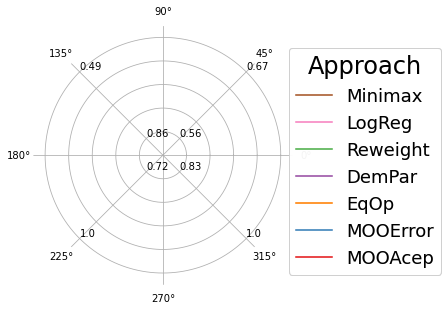

In [137]:
build_radar(ens_results_nof, include_legend=True, acc_min=acc_min_aux, acc_max=acc_max_aux,
            eo_min=eo_min_aux, eo_max=eo_max_aux, dp_min=dp_min_aux, dp_max=dp_max_aux,
            cv_min=cv_min_aux, cv_max=cv_max_aux)

In [109]:
metrics_all.drop(['index'], axis = 1).to_csv("AllModelsResults-ProPublica.csv", index=False)

In [47]:
metrics_all['cv_norm'] = (metrics_all['Coeficiente de variação']-metrics_all['Coeficiente de variação'].max())/(metrics_all['Coeficiente de variação'].min()-metrics_all['Coeficiente de variação'].max())

In [3]:
#metrics_all = pd.read_csv("AllModelsResults-ProPublica.csv")

In [20]:
methods = ['Minimax', 'LogReg', 'Reweight', 'ParDem', 'EqOp', 'MOOErro','MOOAcep']

layout = go.Layout({"showlegend": False},
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis = {'visible': False},
    yaxis = {'visible': False},
    xaxis1=dict(domain=[0, 1/4-0.1],anchor='x1',visible=False, range=[0,500]),
    xaxis2=dict(domain=[1/4, 2/4-0.1],anchor='x2',visible=False, range=[0,500]),
    xaxis3=dict(domain=[2/4, 3/4-0.1],anchor='x3',visible=False, range=[0,500]),
    xaxis4=dict(domain=[3/4, 1-0.1],anchor='x4',visible=False, range=[0,500]),
    xaxis5=dict(domain=[0, 3/4],anchor='x5',visible=False, range=[0,500])
)

fig = go.Figure(layout = layout)#, layout_yaxis_range=[0.4,0.8], layout_xaxis_range=[0,1500])

fig.add_trace(go.Parcoords(
        line = dict(color = metrics_all['model_id'], 
                    colorscale = [(0.0, line_color['Minimax']),(0.14, line_color['Minimax']),
                            (0.14, line_color['LogReg']), (0.28, line_color['LogReg']),
                            (0.28, line_color['Reweight']),(0.42, line_color['Reweight']),
                            (0.42, line_color['ParDem']),(0.56, line_color['ParDem']),
                            (0.56, line_color['EqOp']),(0.7, line_color['EqOp']),
                            (0.7, line_color['MOOErro']),(0.84, line_color['MOOErro']),
                            (0.84, line_color['MOOAcep']),(1.0, line_color['MOOAcep'])], 
                    showscale = False, cmin = 0, cmax = 6,
                   colorbar = {'tickvals': metrics_all['model_id'].tolist(),
                          'ticktext': metrics_all['Modelo'].tolist(),
                              'title': 'Modelo'}),
        dimensions = list([
            dict(range = [0.0,1],
                label = 'Acurácia', values = metrics_all['Acurácia']),
            dict(range = [0,1],
                label = 'Igualdade de Oportunidade', values = metrics_all['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'P porcento', values = metrics_all['P porcento']),
            dict(range = [metrics_all['Coeficiente de variação'].max(),metrics_all['Coeficiente de variação'].min()],
                label = 'Coeficiente de variação', values = metrics_all['Coeficiente de variação']),
        ]),
    domain = {'x': (0, 3/4)}
    ))

i = 1
for metric in ['Acurácia', 'Igualdade de Oportunidade', 'P porcento', 'cv_norm']:
    # Histograma dos outros
    #yo = metrics_all[metrics_all['Modelo']!='MOOErro'][metrics_all['Modelo']!='MOOAcep'][metric]
    #fig.add_trace(go.Histogram(y=yo, name='Outros', xaxis='x'+str(i), 
    #                           ybins=dict(start=0,end=1,size=0.03), marker_color='#729ae1'))

    for method in methods:
        fig.add_trace(go.Histogram(y=metrics_all[metrics_all['Modelo']==method][metric], name=method,
                                   xaxis='x'+str(i), ybins=dict(start=0,end=1,size=0.03),
                                  marker_color=hist_color[method], opacity=1))
    i += 1
    
    
fig.update_layout(barmode='relative')

fig.show()

### Add Filter

In [9]:
filtros = {'Acurácia': {'min': 0.6, 'max': 0.8}, 'Igualdade de Oportunidade': {'min': 0.0, 'max': 1.0},
           'P porcento': {'min': 0.0, 'max': 1.0}, 'cv_norm': {'min': 0.0, 'max': 1.0}}

In [10]:
m_filtered = metrics_all
for metric in ['Acurácia', 'Igualdade de Oportunidade', 'P porcento', 'cv_norm']:
    m_filtered = m_filtered[(m_filtered[metric] >= filtros[metric]['min']) & 
           (m_filtered[metric] <= filtros[metric]['max'])]

In [11]:
m_out = metrics_all.merge(m_filtered, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']

In [12]:
layout = go.Layout({"showlegend": False},
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis = {'visible': False},
    yaxis = {'visible': False},
    xaxis1=dict(domain=[0, 1/4-0.1],anchor='x1',visible=False, range=[0,500]),
    xaxis2=dict(domain=[1/4, 2/4-0.1],anchor='x2',visible=False, range=[0,500]),
    xaxis3=dict(domain=[2/4, 3/4-0.1],anchor='x3',visible=False, range=[0,500]),
    xaxis4=dict(domain=[3/4, 1-0.1],anchor='x4',visible=False, range=[0,500]),
    xaxis5=dict(domain=[0, 3/4],anchor='x5',visible=False, range=[0,500])
)

fig = go.Figure(layout = layout)#, layout_yaxis_range=[0.4,0.8], layout_xaxis_range=[0,1500])

fig.add_trace(go.Parcoords(
        line = dict(color = metrics_all['model_id'], 
                    colorscale = [(0.0, line_color['Minimax']),(0.14, line_color['Minimax']),
                            (0.14, line_color['LogReg']), (0.28, line_color['LogReg']),
                            (0.28, line_color['Reweight']),(0.42, line_color['Reweight']),
                            (0.42, line_color['ParDem']),(0.56, line_color['ParDem']),
                            (0.56, line_color['EqOp']),(0.7, line_color['EqOp']),
                            (0.7, line_color['MOOErro']),(0.84, line_color['MOOErro']),
                            (0.84, line_color['MOOAcep']),(1.0, line_color['MOOAcep'])], 
                    showscale = False, cmin = 0, cmax = 6,
                   colorbar = {'tickvals': metrics_all['model_id'].tolist(),
                          'ticktext': metrics_all['Modelo'].tolist(),
                              'title': 'Modelo'}),
        dimensions = list([
            dict(range = [metrics_all['Acurácia'].min(),metrics_all['Acurácia'].max()],
                constraintrange = [filtros['Acurácia']['min'],filtros['Acurácia']['max']],
                label = 'Acurácia', values = metrics_all['Acurácia']),
            dict(range = [0,1],
                label = 'Igualdade de Oportunidade', values = metrics_all['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'P porcento', values = metrics_all['P porcento']),
            dict(range = [metrics_all['Coeficiente de variação'].max(),metrics_all['Coeficiente de variação'].min()],
                label = 'Coeficiente de variação', values = metrics_all['Coeficiente de variação']),
        ]),
    domain = {'x': (0, 3/4)}
    ))

i = 1
for metric in ['Acurácia', 'Igualdade de Oportunidade', 'P porcento', 'cv_norm']:
    #fig.add_trace(go.Histogram(y=m_out[metric], name="out",
    #                               xaxis='x'+str(i), ybins=dict(start=0,end=1,size=0.03),
    #                              marker_color="#9a9a9a"))
    for method in methods:
        fig.add_trace(go.Histogram(y=m_filtered[m_filtered['Modelo']==method][metric], name=method,
                                   xaxis='x'+str(i), ybins=dict(start=metrics_all[metric].min(),
                                                                end=metrics_all[metric].max(),size=0.03),
                                  marker_color=hist_color[method]))
    i += 1

    
    
fig.update_layout(barmode='stack')

fig.show()

In [13]:
layout = go.Layout({"showlegend": False},
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis = {'visible': False},
    yaxis = {'visible': False},
    xaxis1=dict(domain=[0, 1/4-0.1],anchor='x1',visible=False, range=[0,500]),
    xaxis2=dict(domain=[1/4, 2/4-0.1],anchor='x2',visible=False, range=[0,500]),
    xaxis3=dict(domain=[2/4, 3/4-0.1],anchor='x3',visible=False, range=[0,500]),
    xaxis4=dict(domain=[3/4, 1-0.1],anchor='x4',visible=False, range=[0,500]),
    xaxis5=dict(domain=[0, 3/4],anchor='x5',visible=False, range=[0,500])
)

fig = go.Figure(layout = layout)#, layout_yaxis_range=[0.4,0.8], layout_xaxis_range=[0,1500])

fig.add_trace(go.Parcoords(
        line = dict(color = metrics_all['model_id'], 
                    colorscale = [(0.0, line_color['Minimax']),(0.14, line_color['Minimax']),
                            (0.14, line_color['LogReg']), (0.28, line_color['LogReg']),
                            (0.28, line_color['Reweight']),(0.42, line_color['Reweight']),
                            (0.42, line_color['ParDem']),(0.56, line_color['ParDem']),
                            (0.56, line_color['EqOp']),(0.7, line_color['EqOp']),
                            (0.7, line_color['MOOErro']),(0.84, line_color['MOOErro']),
                            (0.84, line_color['MOOAcep']),(1.0, line_color['MOOAcep'])], 
                    showscale = False, cmin = 0, cmax = 6,
                   colorbar = {'tickvals': metrics_all['model_id'].tolist(),
                          'ticktext': metrics_all['Modelo'].tolist(),
                              'title': 'Modelo'}),
        dimensions = list([
            dict(range = [0.0,1],
                constraintrange = [filtros['Acurácia']['min'],filtros['Acurácia']['max']],
                label = 'Acurácia', values = metrics_all['Acurácia']),
            dict(range = [0,1],
                label = 'Igualdade de Oportunidade', values = metrics_all['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'P porcento', values = metrics_all['P porcento']),
            dict(range = [metrics_all['Coeficiente de variação'].max(),metrics_all['Coeficiente de variação'].min()],
                label = 'Coeficiente de variação', values = metrics_all['Coeficiente de variação']),
        ]),
    domain = {'x': (0, 3/4)}
    ))

fig.show()

In [14]:
layout = go.Layout({"showlegend": False},
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis = {'visible': False},
    yaxis = {'visible': False},
    xaxis1=dict(domain=[0, 1/4-0.1],anchor='x1',visible=False, range=[0,500]),
    xaxis2=dict(domain=[1/4, 2/4-0.1],anchor='x2',visible=False, range=[0,500]),
    xaxis3=dict(domain=[2/4, 3/4-0.1],anchor='x3',visible=False, range=[0,500]),
    xaxis4=dict(domain=[3/4, 1-0.1],anchor='x4',visible=False, range=[0,500]),
    xaxis5=dict(domain=[0, 3/4],anchor='x5',visible=False, range=[0,500])
)

fig = go.Figure(layout = layout)

i = 1
for metric in ['Acurácia', 'Igualdade de Oportunidade', 'P porcento', 'cv_norm']:
    #fig.add_trace(go.Histogram(y=m_out[metric], name="out",
    #                               xaxis='x'+str(i), ybins=dict(start=0,end=1,size=0.03),
    #                              marker_color="#cecece"))
    for method in methods:
        fig.add_trace(go.Histogram(y=m_filtered[m_filtered['Modelo']==method][metric], name=method,
                                   xaxis='x'+str(i), ybins=dict(start=0,end=1,size=0.03),
                                  marker_color=hist_color[method]))
    i += 1

    
    
fig.update_layout(barmode='stack')

fig.show()

In [15]:
layout = go.Layout({"showlegend": False},
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis = {'visible': False},
    yaxis = {'visible': False},
    xaxis1=dict(domain=[0, 1/4-0.1],anchor='x1',visible=False, range=[0,500]),
    xaxis2=dict(domain=[1/4, 2/4-0.1],anchor='x2',visible=False, range=[0,500]),
    xaxis3=dict(domain=[2/4, 3/4-0.1],anchor='x3',visible=False, range=[0,500]),
    xaxis4=dict(domain=[3/4, 1-0.1],anchor='x4',visible=False, range=[0,500]),
    xaxis5=dict(domain=[0, 3/4],anchor='x5',visible=False, range=[0,500])
)

fig = go.Figure(layout = layout)#, layout_yaxis_range=[0.4,0.8], layout_xaxis_range=[0,1500])

fig.add_trace(go.Parcoords(
        line = dict(color = m_filtered['model_id'], 
                    colorscale = [(0.0, line_color['Minimax']),(0.14, line_color['Minimax']),
                            (0.14, line_color['LogReg']), (0.28, line_color['LogReg']),
                            (0.28, line_color['Reweight']),(0.42, line_color['Reweight']),
                            (0.42, line_color['ParDem']),(0.56, line_color['ParDem']),
                            (0.56, line_color['EqOp']),(0.7, line_color['EqOp']),
                            (0.7, line_color['MOOErro']),(0.84, line_color['MOOErro']),
                            (0.84, line_color['MOOAcep']),(1.0, line_color['MOOAcep'])], 
                    showscale = False, cmin = 0, cmax = 6,
                   colorbar = {'tickvals': m_filtered['model_id'].tolist(),
                          'ticktext': m_filtered['Modelo'].tolist(),
                              'title': 'Modelo'}),
        dimensions = list([
            dict(range = [0.0,1],
                 constraintrange = [filtros['Acurácia']['min'],filtros['Acurácia']['max']],
                label = 'Acurácia', values = m_filtered['Acurácia']),
            dict(range = [0,1],
                label = 'Igualdade de Oportunidade', values = m_filtered['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'P porcento', values = m_filtered['P porcento']),
            dict(range = [metrics_all['Coeficiente de variação'].max(),metrics_all['Coeficiente de variação'].min()],
                label = 'Coeficiente de variação', values = m_filtered['Coeficiente de variação']),
        ]),
    domain = {'x': (0, 3/4)}
    ))

i = 1
for metric in ['Acurácia', 'Igualdade de Oportunidade', 'P porcento', 'cv_norm']:
    #fig.add_trace(go.Histogram(y=m_out[metric], name="out",
    #                               xaxis='x'+str(i), ybins=dict(start=0,end=1,size=0.03),
    #                              marker_color="#cecece"))
    for method in methods:
        fig.add_trace(go.Histogram(y=m_filtered[m_filtered['Modelo']==method][metric], name=method,
                                   xaxis='x'+str(i), ybins=dict(start=0,end=1,size=0.03),
                                  marker_color=hist_color[method]))
    i += 1
    
    
fig.update_layout(barmode='stack')

fig.show()

In [25]:
m_filtered["Acurácia"].max()

0.6742301458670988

In [16]:
layout = go.Layout({"showlegend": False},
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis = {'visible': False},
    yaxis = {'visible': False},
    xaxis1=dict(domain=[0, 1/4-0.1],anchor='x1',visible=False, range=[0,500]),
    xaxis2=dict(domain=[1/4, 2/4-0.1],anchor='x2',visible=False, range=[0,500]),
    xaxis3=dict(domain=[2/4, 3/4-0.1],anchor='x3',visible=False, range=[0,500]),
    xaxis4=dict(domain=[3/4, 1-0.1],anchor='x4',visible=False, range=[0,500]),
    xaxis5=dict(domain=[0, 3/4],anchor='x5',visible=False, range=[0,500])
)

fig = go.Figure(layout = layout)#, layout_yaxis_range=[0.4,0.8], layout_xaxis_range=[0,1500])

fig.add_trace(go.Parcoords(
        line = dict(color = "#cecece"),
        dimensions = list([
            dict(range = [0.0,1],
                label = 'Acurácia', values = m_out['Acurácia']),
            dict(range = [0,1],
                label = 'Igualdade de Oportunidade', values = m_out['Igualdade de Oportunidade']),
            dict(range = [0,1],
                label = 'P porcento', values = m_out['P porcento']),
            dict(range = [metrics_all['Coeficiente de variação'].max(),metrics_all['Coeficiente de variação'].min()],
                label = 'Coeficiente de variação', values = m_out['Coeficiente de variação']),
        ]),
    domain = {'x': (0, 3/4)}
    ))

fig.show()

In [28]:
metrics_all.groupby("Modelo").count()

,index,Acurácia,Igualdade de Oportunidade,P porcento,Coeficiente de variação,model_id,cv_norm
Modelo,,,,,,,
EqOp,384,384,384,384,384,384,384
LogReg,50,50,50,50,50,50,50
MOOAcep,150,150,150,150,150,150,150
MOOErro,150,150,150,150,150,150,150
Minimax,50,50,50,50,50,50,50
ParDem,400,400,400,400,400,400,400
Reweight,50,50,50,50,50,50,50
